In [41]:
import pandas as pd
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
def colormap(metric, title, runs):
    cmap = "cool_r"
    fig, ax = plt.subplots()
    _metric = runs[f"metrics.{metric}"]
    g = sns.scatterplot(x="params.size", y="params.overlap", data=runs, c=_metric, cmap=cmap, size=_metric,
                        legend=False)
    g.set_xlabel("Subset Size")
    g.set_ylabel("Overlap")

    # color bar
    norm = plt.Normalize(_metric.min(), _metric.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.06, ax.get_position().height / 2])
    ax.figure.colorbar(sm, cax=cax)

    plt.suptitle(title)

In [43]:
def compare_metrics(data, param, param_name, title):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, ax = plt.subplots(1, 3, sharey=True)
    sns.boxplot(data=data, x=f"params.{param}", y="metrics.precision", ax=ax[0])
    sns.boxplot(data=data, x=f"params.{param}", y="metrics.recall", ax=ax[1])
    sns.boxplot(data=data, x=f"params.{param}", y="metrics.fscore", ax=ax[2])
    ax[0].set_ylabel("Precision")
    ax[1].set_ylabel("Recall")
    ax[2].set_ylabel("F1-Score")
    for x in ax.flatten():
        x.xaxis.set_tick_params(labelbottom=True)
        x.yaxis.set_tick_params(labelleft=True)
    [x.set_xlabel(param_name) for x in ax]
    fig.suptitle(title)

# Base Dataset

In [44]:
filepath = "data/2021_NCVR_Panse_001/dataset_ncvr_dirty.csv"
col_names = "sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE".split(",")
df = pd.read_csv(filepath, names=col_names)
df.shape[0]

200000

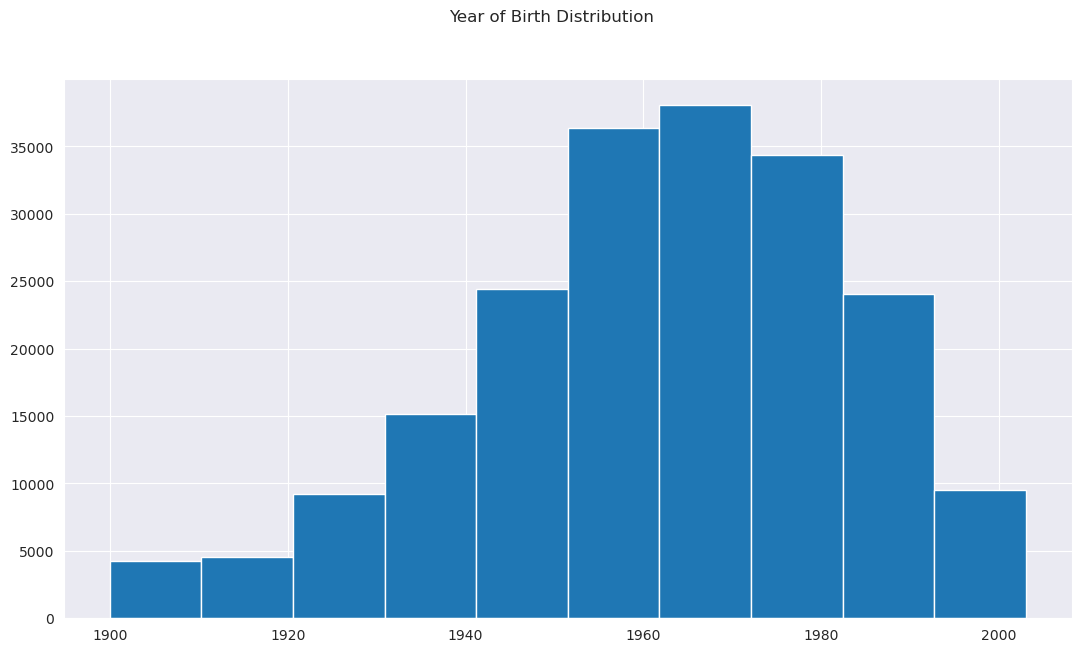

In [45]:
df["YEAROFBIRTH"].hist(figsize=[13, 7])
plt.suptitle("Year of Birth Distribution")
plt.savefig("plots/distr/yob.png")

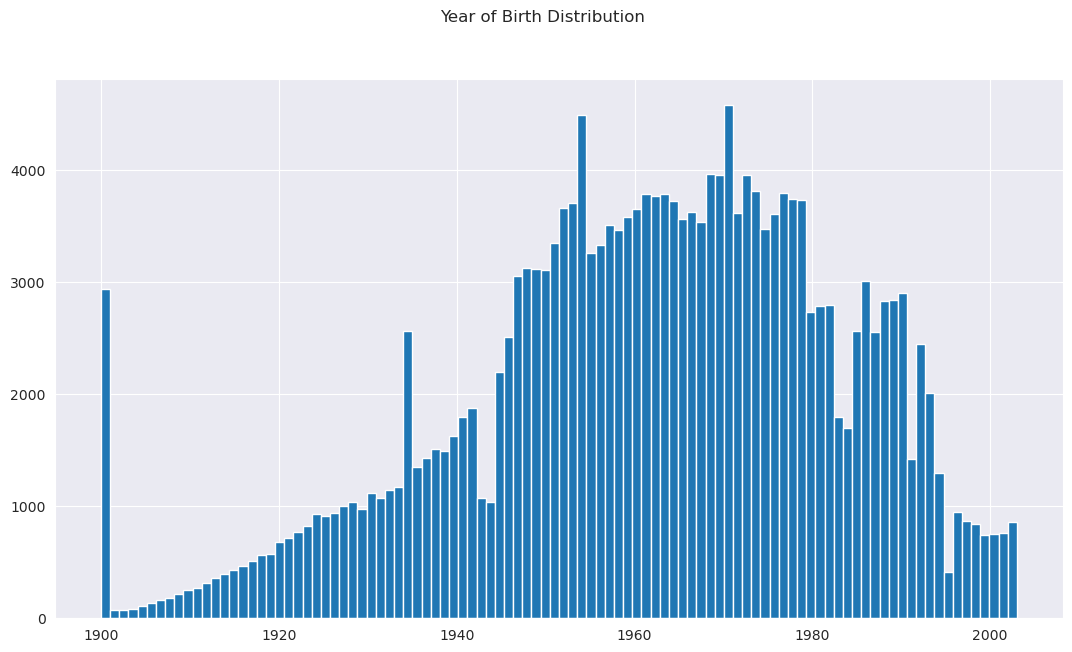

In [46]:
df["YEAROFBIRTH"].hist(bins=100, figsize=[13, 7])
plt.suptitle("Year of Birth Distribution")
plt.savefig("plots/distr/yob100.png")

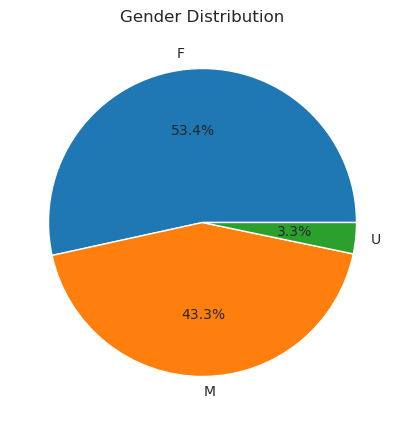

In [47]:
gender_dist = df.groupby(["GENDER"]).size()
plt.pie(x=[v for _, v in gender_dist.items()], labels=[k for k, _ in gender_dist.items()], autopct='%1.1f%%')
plt.title("Gender Distribution")
plt.savefig("plots/distr/gender.png")

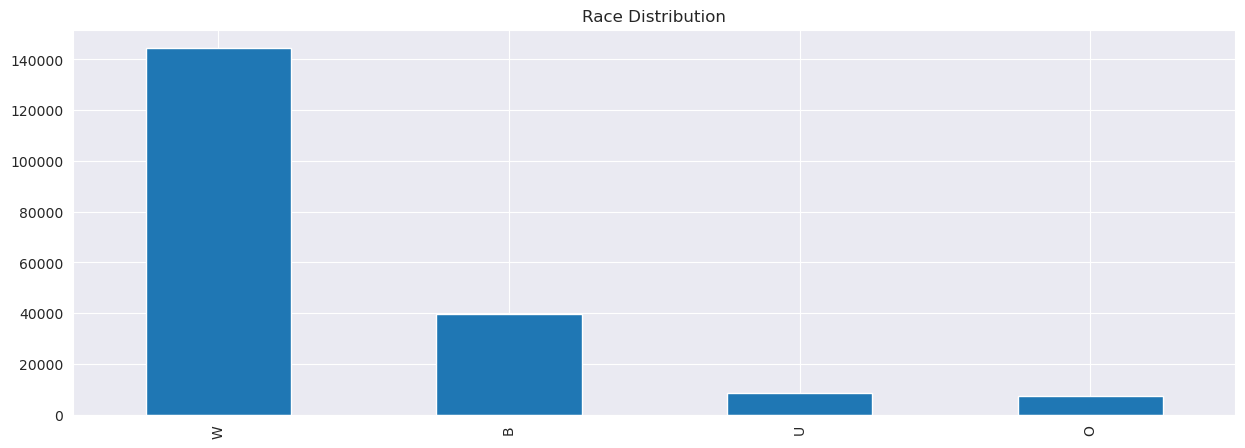

In [48]:
df.RACE.map(lambda v: "O" if v in ["I", "A", "M", "P"] else v).value_counts().plot.bar(title="Race Distribution")
plt.savefig("plots/distr/race.png")

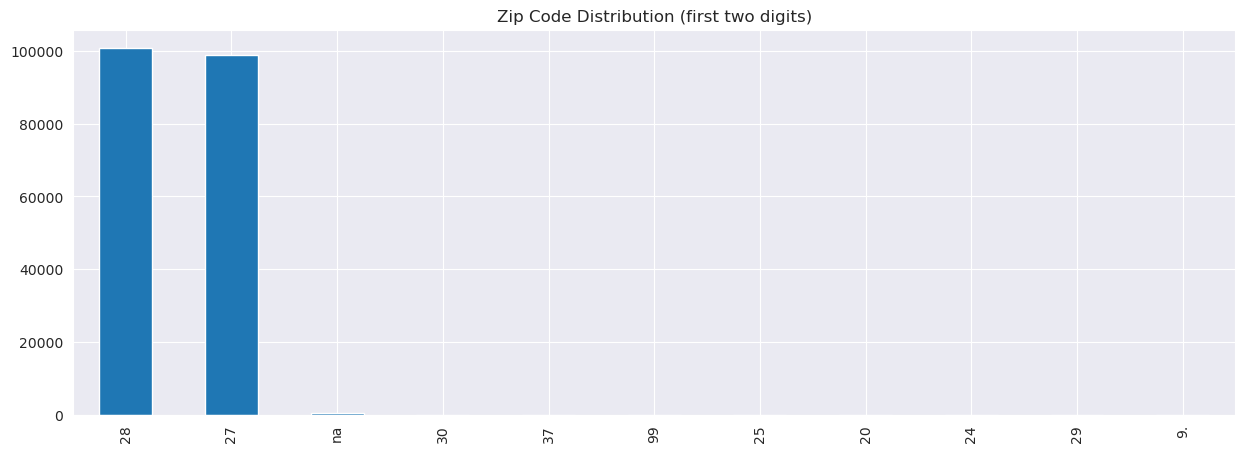

In [49]:
df.PLZ.map(lambda plz: str(plz)[:2]).value_counts().plot.bar(title="Zip Code Distribution (first two digits)")
plt.savefig("plots/distr/plz2.png")

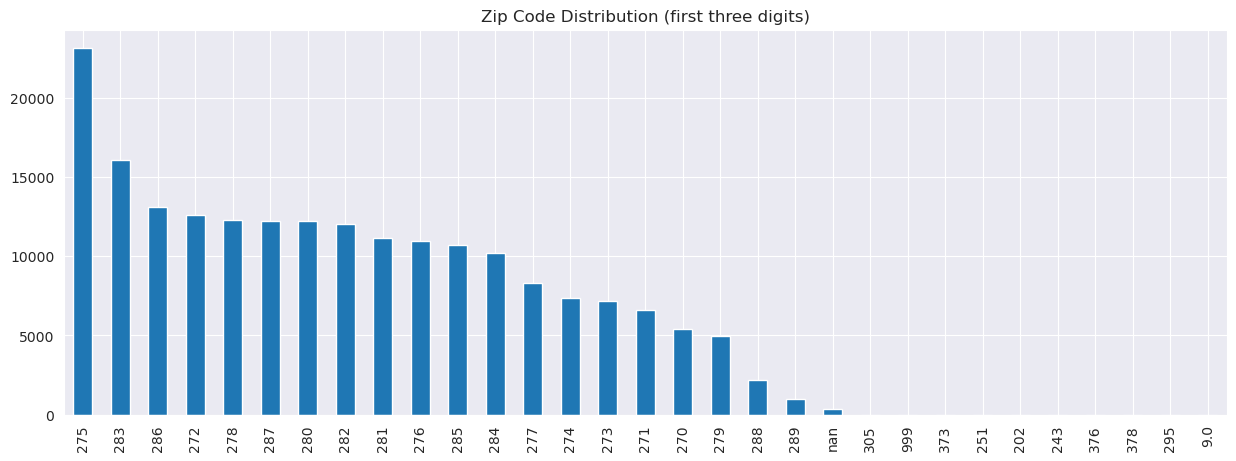

In [50]:
df.PLZ.map(lambda plz: str(plz)[:3]).value_counts().plot.bar(title="Zip Code Distribution (first three digits)")
plt.savefig("plots/distr/plz3.png")

## Random subsets

In [51]:
runs_random_varying_sizes_and_overlaps = mlflow.search_runs(experiment_ids=["651112999057083515"])  # cartesian product from many sizes and overlaps, using 10 seeds per value pair
runs_random_varying_sizes = mlflow.search_runs(experiment_ids=["510907071686288999"])  # overlap = 0.2 and many sizes, using 26 seeds per value
len(runs_random_varying_sizes_and_overlaps)

1290

In [52]:
runs_random_varying_sizes_and_overlaps = runs_random_varying_sizes_and_overlaps.apply(pd.to_numeric, errors="ignore")
runs_random_varying_sizes = runs_random_varying_sizes.apply(pd.to_numeric, errors="ignore")

In [53]:
runs_random_mean = runs_random_varying_sizes_and_overlaps.groupby(by=["params.overlap", "params.size"]).mean()
len(runs_random_mean)

/tmp/ipykernel_50416/182597946.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  runs_random_mean = runs_random_varying_sizes_and_overlaps.groupby(by=["params.overlap", "params.size"]).mean()


129

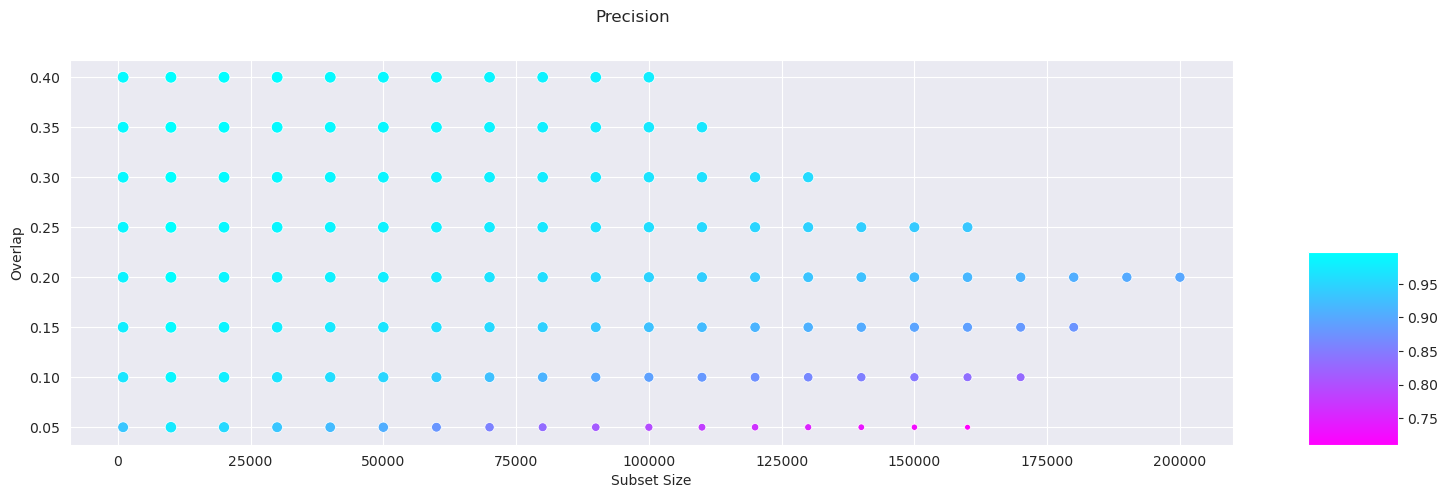

In [54]:
colormap("precision", "Precision", runs_random_mean)
plt.savefig("plots/colormaps/p.png")

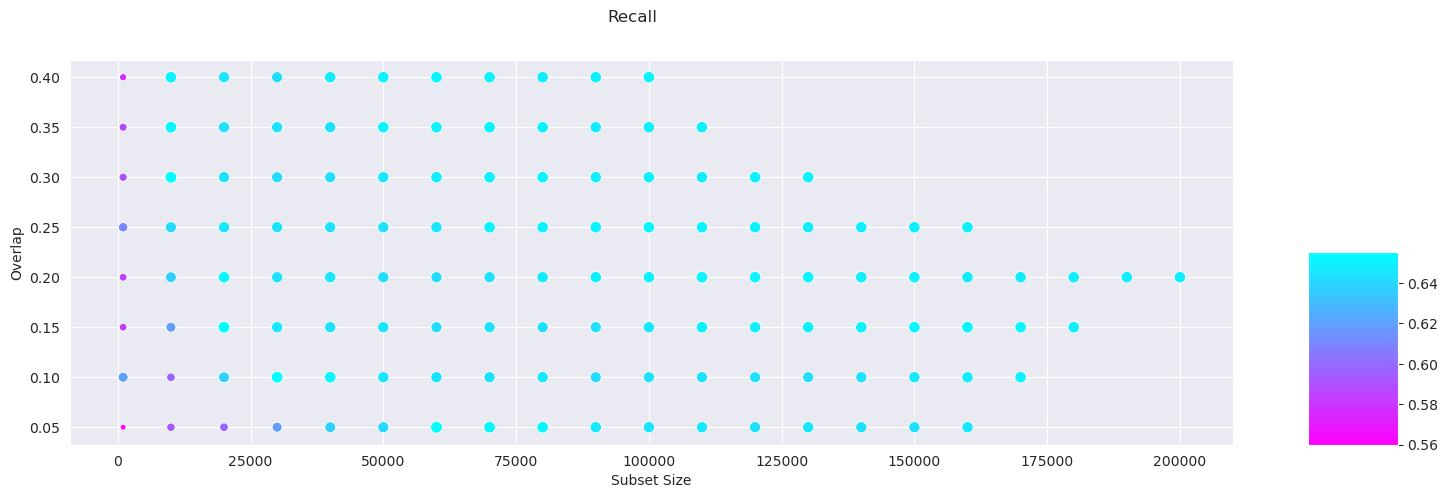

In [55]:
colormap("recall", "Recall", runs_random_mean)
plt.savefig("plots/colormaps/r.png")

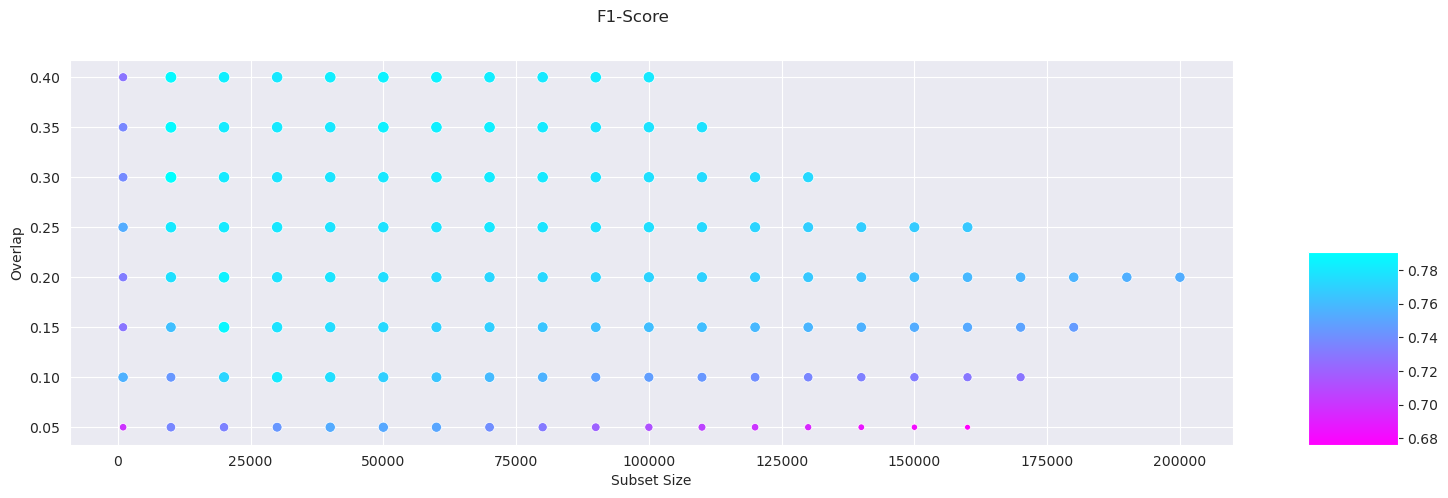

In [56]:
colormap("fscore", "F1-Score", runs_random_mean)
plt.savefig("plots/colormaps/f.png")

### Influence of subset size

In [57]:
# set figure size
plt.rcParams['figure.figsize'] = [8, 6]

In [58]:
def box_plot(data, param: (str, str), metric: (str, str), ylim=None):
    m_name, m_label = metric
    p_name, p_label = param
    sns.boxplot(data=data, x=f"params.{p_name}", y=f"metrics.{m_name}",  color="C0")
    plt.xlabel(p_label)
    plt.ylabel(m_label)
    plt.xticks(rotation=45)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()

In [59]:
M_NAMES = ["precision", "recall", "fscore"]
M_LABELS = ["Precision", "Recall", "F1-Score"]

def influence_of_a(runs, a_name, a_label, b_name, b_val, ylim=None):
    runs_fixed_b = runs[runs[f"params.{b_name}"] == b_val]
    for m in zip(M_NAMES, M_LABELS):
        box_plot(data=runs_fixed_b, param=(a_name, a_label), metric=m, ylim=ylim)
        plt.savefig(f"plots/random/{a_label}_{m[1]}.png")

In [60]:
overlap = 0.2

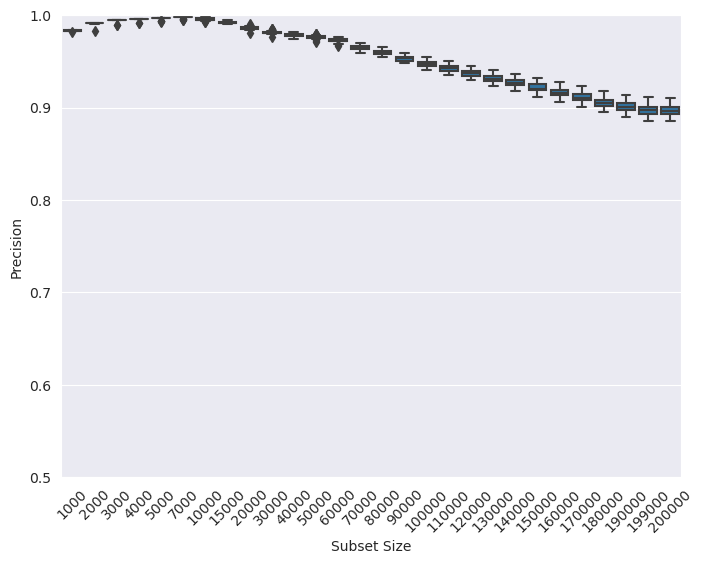

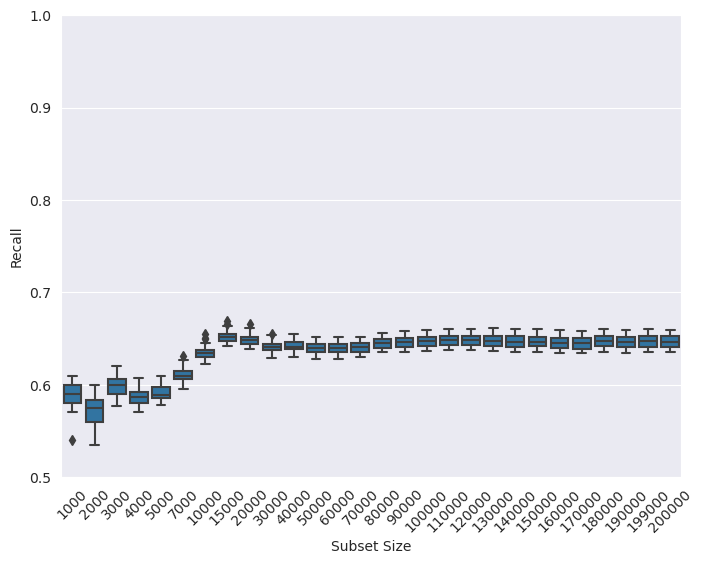

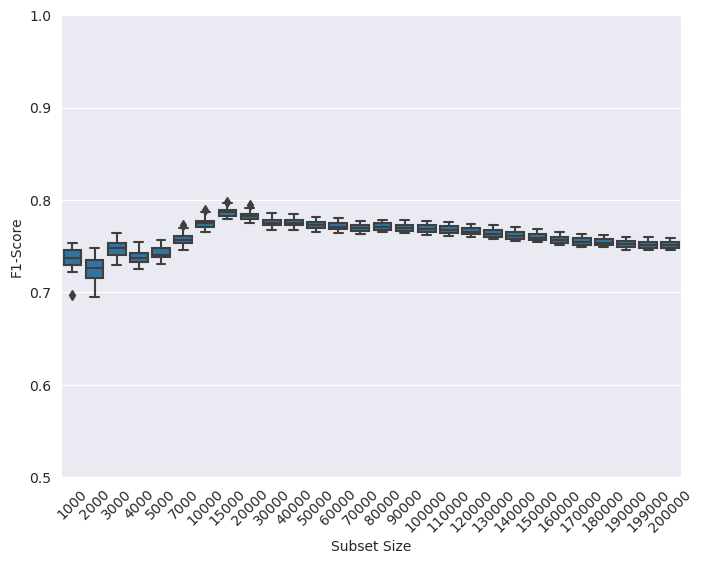

<Figure size 800x600 with 0 Axes>

In [61]:
influence_of_a(runs_random_varying_sizes, a_name="size", a_label="Subset Size", b_name="overlap", b_val=overlap, ylim=[.5, 1])

### Influence of Overlap

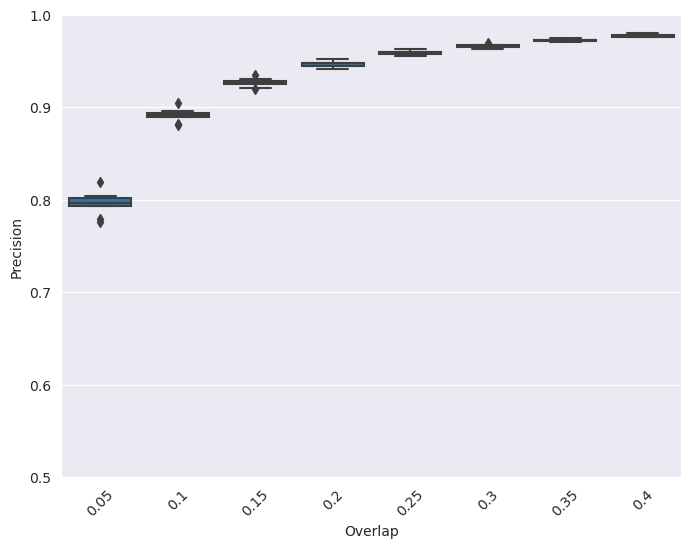

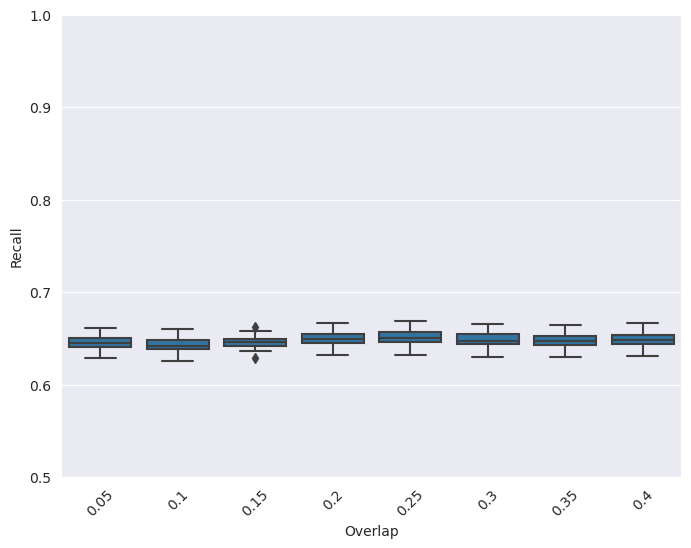

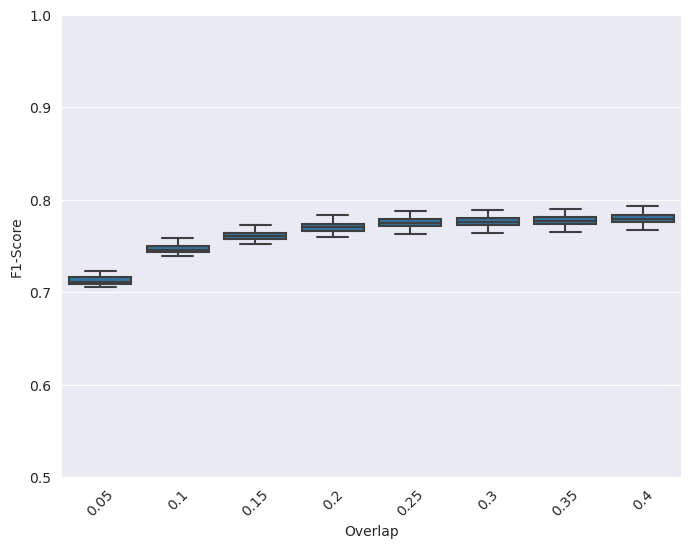

<Figure size 800x600 with 0 Axes>

In [62]:
size = 100_000
influence_of_a(runs_random_varying_sizes_and_overlaps, a_name="overlap", a_label="Overlap", b_name="size", b_val=size, ylim=[.5, 1])

# Age, PLZ, Gender Subsets

In [63]:
runs_age_plz_gender = mlflow.search_runs(experiment_ids=["337062275817683573", "331509985598984853"])
runs_age = runs_age_plz_gender[runs_age_plz_gender["params.subset_selection"] == "AGE"]
runs_plz = runs_age_plz_gender[runs_age_plz_gender["params.subset_selection"] == "PLZ"]
runs_gender = runs_age_plz_gender[(runs_age_plz_gender["params.subset_selection"] == "ATTRIBUTE_VALUE")
                                  & (runs_age_plz_gender["params.column"] == "GENDER")]

In [64]:
runs_plz3 = mlflow.search_runs(experiment_ids=["278314973829801495"])

## Age

In [65]:
map_age_range = {
    "[20, 39]": "0-39",
    "[40, 59]": "40-59",
    "[60, 1000]": ">60"
}
runs_age["params.range"] = runs_age["params.range"].apply(lambda v: map_age_range.get(v, v))
runs_age = runs_age.sort_values(by="params.range")

/tmp/ipykernel_50416/2350726381.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_age["params.range"] = runs_age["params.range"].apply(lambda v: map_age_range.get(v, v))


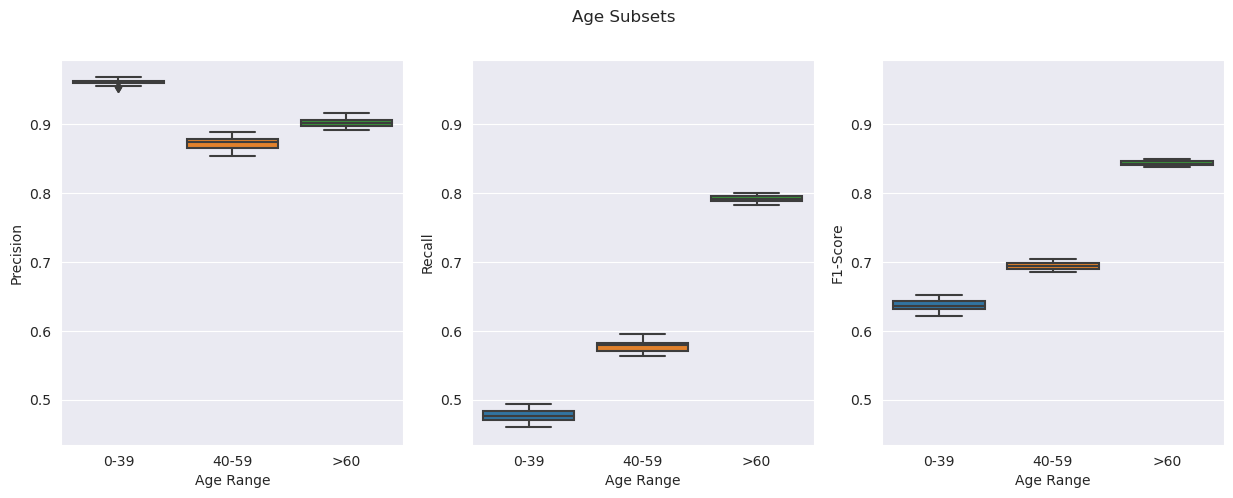

In [66]:
compare_metrics(runs_age, "range", "Age Range", "Age Subsets")
plt.savefig("plots/attr/age.png")

0-39:
* precision high -> not many FP
* recall low -> many FN
* -> need lower t or lower k ?

## PLZ

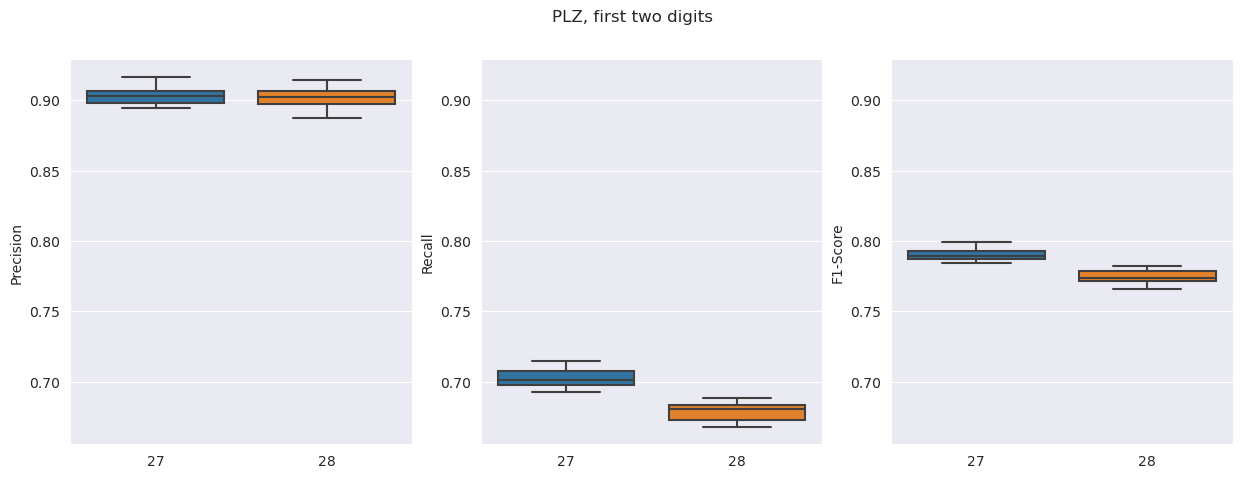

In [67]:
compare_metrics(runs_plz, "equals", "", "PLZ, first two digits")
plt.savefig("plots/attr/plz2.png")

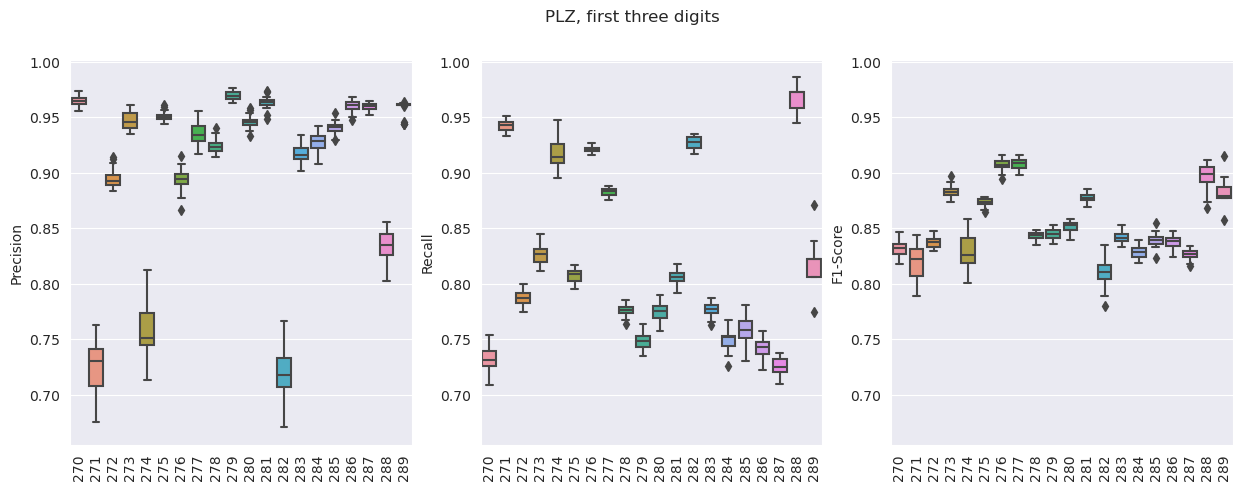

In [74]:
data = runs_plz3.sort_values(by=["params.equals"]); param = "equals"
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1, 3, sharey=True)
sns.boxplot(data=data, x=f"params.{param}", y="metrics.precision", ax=ax[0])
sns.boxplot(data=data, x=f"params.{param}", y="metrics.recall", ax=ax[1])
sns.boxplot(data=data, x=f"params.{param}", y="metrics.fscore", ax=ax[2])
ax[0].set_ylabel("Precision")
ax[1].set_ylabel("Recall")
ax[2].set_ylabel("F1-Score")
for x in ax.flatten():
    x.xaxis.set_tick_params(labelbottom=True, rotation=90)
    x.yaxis.set_tick_params(labelleft=True)
[x.set_xlabel("") for x in ax]
fig.suptitle("PLZ, first three digits")
plt.savefig("plots/attr/plz3.png")

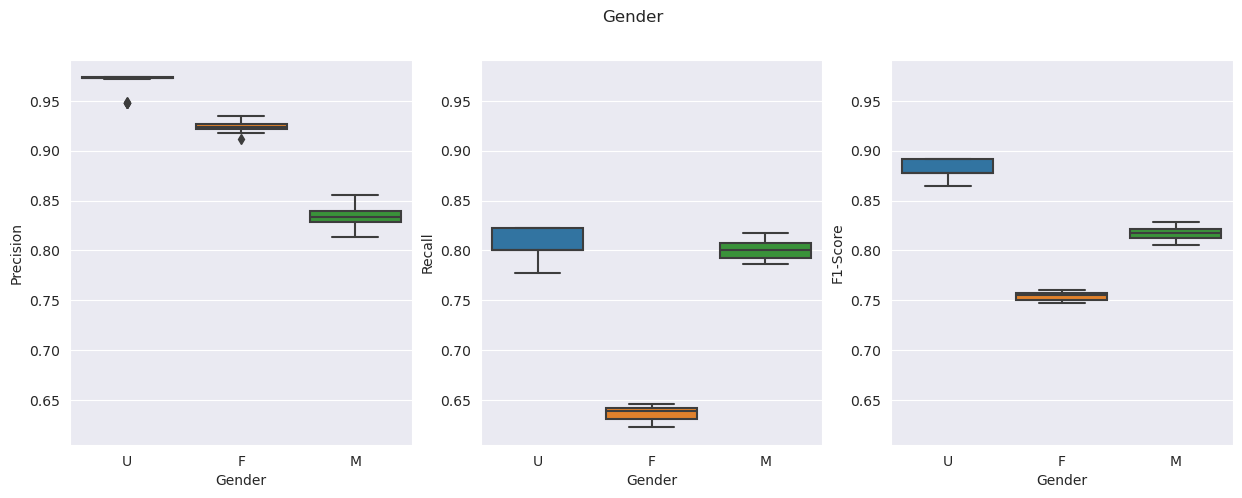

In [69]:
compare_metrics(runs_gender, "equals", "Gender", "Gender")
plt.savefig("plots/attr/gender.png")